In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from helpers import *

In [2]:
# === CONFIG === #
N_SIM = 10000
ELO_SIGMA = 100.0      # scale of algorithmic ELO calculation
ALPHA = 1.0            # weight of ppg (points per game)
BETA = 0.8             # weight of gd_pg (goal diff per game)
GAMMA = 0.2            # weight of gf_pg (goals scored per game)
K_FACTOR = 20          # ELO update factor
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# === Actual table status === #
teams_data = {
    "EKO-RAFF":     {"M":6, "W":5, "D":0, "L":1, "GF":40, "GA":17, "GD":23,  "Pts":15},
    "Cyrkulatka":   {"M":7, "W":6, "D":0, "L":1, "GF":34, "GA":24, "GD":10,  "Pts":18},
    "Fakel":        {"M":7, "W":5, "D":0, "L":2, "GF":28, "GA":17, "GD":11,  "Pts":15},
    "Banger W-wa":  {"M":7, "W":5, "D":0, "L":2, "GF":41, "GA":23, "GD":18,  "Pts":15},
    "Inferno Team": {"M":7, "W":4, "D":0, "L":3, "GF":34, "GA":31, "GD":3,   "Pts":12},
    "KPT Warszawa": {"M":7, "W":3, "D":1, "L":3, "GF":22, "GA":25, "GD":-3,  "Pts":10},
    "Blic Team":    {"M":7, "W":1, "D":1, "L":5, "GF":24, "GA":34, "GD":-10, "Pts":4},
    "Tune Squad":   {"M":7, "W":1, "D":1, "L":5, "GF":21, "GA":37, "GD":-13, "Pts":4},
    "CPI":          {"M":6, "W":1, "D":1, "L":4, "GF":17, "GA":45, "GD":-28, "Pts":3},
    "Mitra":        {"M":7, "W":0, "D":2, "L":5, "GF":19, "GA":30, "GD":-11, "Pts":2}
}

teams = list(teams_data.keys())

In [4]:
# === Manual ELO ratings (optional) === #
manual_elo = {
    # "Fakel": 1560,
    # "Cyrkulatka": 1550,
    # ...
}
# If manual_elo is empty, an algorithmic way of calculating ELO will be used

In [5]:
# === Make sure to insert remaining matches below === #
remaining_matches = [
    ("EKO-RAFF","Banger W-wa"), ("Inferno Team","KPT Warszawa"), ("Blic Team","Mitra"), ("Cyrkulatka","Tune Squad"), ("CPI","Fakel"),
    ("CPI","EKO-RAFF"),
    ("Tune Squad","KPT Warszawa"), ("Fakel","EKO-RAFF"), ("Cyrkulatka","CPI"), ("Inferno Team","Mitra"), ("Blic Team","Banger W-wa")
]

In [6]:
# === Compute initial Elo ratings === #
if manual_elo:
    elo0 = manual_elo.copy()
    # ensure all teams present
    for t in teams:
        if t not in elo0:
            elo0[t] = 1500
else:
    elo0 = compute_auto_elo(teams_data, alpha=ALPHA, beta=BETA, gamma=GAMMA, sigma=ELO_SIGMA)

print("Starting ELO:")
for t in teams:
    print(f"  {t:15s}: {elo0[t]}")

BASE_GOALS = calculate_base_goals(teams_data)

print(f"\nNumber of simulations: {N_SIM}")
print(f"Number of remaining matches: {len(remaining_matches)}")
print(f"Base goals per team: {BASE_GOALS:.3f}")

Starting ELO:
  EKO-RAFF       : 1660
  Cyrkulatka     : 1583
  Fakel          : 1567
  Banger W-wa    : 1607
  Inferno Team   : 1526
  KPT Warszawa   : 1481
  Blic Team      : 1426
  Tune Squad     : 1411
  CPI            : 1330
  Mitra          : 1407

Number of simulations: 10000
Number of remaining matches: 11
Base goals per team: 4.118


In [7]:
# === SIMULATIONS WITH POISSON-BASED GOALS === #
results_count = {t: np.zeros(len(teams)+1, dtype=int) for t in teams}  # positions 1..10 prep array
points_initial = {t: teams_data[t]["Pts"] for t in teams}
gd_initial = {t: teams_data[t]["GD"] for t in teams}
gf_initial = {t: teams_data[t]["GF"] for t in teams}
ga_initial = {t: teams_data[t]["GA"] for t in teams}
games_played_initial = {t: teams_data[t]["M"] for t in teams}
points_for_title = []
points_for_safety = []
match_goals = {
    pair: {"goals_a": 0, "goals_b": 0, "count": 0} 
    for pair in remaining_matches}
match_outcomes = {
    pair: {"A_wins": 0, "Draws": 0, "B_wins": 0, "count": 0}
    for pair in remaining_matches
}
base_lambda, attack, defense = init_attack_defense(teams_data)

for sim in range(N_SIM):
    if sim % 1000 == 0:
        print(f"Simulation {sim}/{N_SIM}")
    pts = points_initial.copy()
    gd = gd_initial.copy()
    gf = gf_initial.copy()
    ga = ga_initial.copy()
    elo = elo0.copy()
    games_played = games_played_initial.copy()

    for (a, b) in remaining_matches:
        goals_a, goals_b = simulate_goals(
            a, b, base_lambda, attack, defense,
            elo_a=elo[a], elo_b=elo[b], elo_factor=800, draw_bias=0.1)
        
        # store goals info to estimate match results
        match_goals[(a, b)]["goals_a"] += goals_a
        match_goals[(a, b)]["goals_b"] += goals_b
        match_goals[(a, b)]["count"] += 1
        # track W/D/L outcomes
        match_outcomes[(a, b)]["count"] += 1
        if goals_a > goals_b:
            match_outcomes[(a, b)]["A_wins"] += 1
        elif goals_a < goals_b:
            match_outcomes[(a, b)]["B_wins"] += 1
        else:
            match_outcomes[(a, b)]["Draws"] += 1

        gf[a] += goals_a
        gf[b] += goals_b
        ga[a] += goals_b
        ga[b] += goals_a
        gd[a] = gf[a] - ga[a]
        gd[b] = gf[b] - ga[b]
        games_played[a] += 1
        games_played[b] += 1

        S_A, S_B = get_match_result(goals_a, goals_b)
        
        if S_A == 1.0:  # Team A wins
            pts[a] += 3
        elif S_A == 0.5:  # Draw
            pts[a] += 1
            pts[b] += 1
        else:  # Team B wins
            pts[b] += 3

        elo[a], elo[b] = update_elo(elo[a], elo[b], S_A, S_B, K=K_FACTOR)
        base_lambda, attack, defense = fast_recompute_attack_defense(gf, ga, games_played)

    # sort teams by points, then goal difference, then goals for, then goals conceded
    items = list(pts.items())
    random.shuffle(items)  # shuffle to avoid bias in equal keys (but in this case it's not strictly necessary, due to the goal stats tracking)
    items.sort(key=lambda x: (x[1], gd[x[0]], gf[x[0]], -ga[x[0]]), reverse=True)

    points_for_title.append(items[0][1])   # store points for 1st place
    points_for_safety.append(items[7][1])  # store points for 8th place

    for pos, (team, p) in enumerate(items, start=1):
        results_count[team][pos] += 1

Simulation 0/10000
Simulation 1000/10000
Simulation 2000/10000
Simulation 3000/10000
Simulation 4000/10000
Simulation 5000/10000
Simulation 6000/10000
Simulation 7000/10000
Simulation 8000/10000
Simulation 9000/10000


In [8]:
# === Remaining matches summary === #
records = []
for (a, b), stats in match_outcomes.items():
    total = stats["count"]
    if total > 0:
        records.append({
            "Team A": a,
            "Avg Goals A": match_goals[(a,b)]["goals_a"] / total,
            "A_win_%": stats["A_wins"] / total * 100,
            "Draw_%":  stats["Draws"] / total * 100,
            "B_win_%": stats["B_wins"] / total * 100,
            "Avg Goals B": match_goals[(a,b)]["goals_b"] / total,
            "Team B": b
        })

df_match_summary = pd.DataFrame(records)
df_match_summary = df_match_summary.round(2)
display(df_match_summary)

,Team A,Avg Goals A,A_win_%,Draw_%,B_win_%,Avg Goals B,Team B
0,EKO-RAFF,8.68,83.08,12.78,4.14,3.22,Banger W-wa
1,Inferno Team,4.49,60.83,20.80,18.37,2.93,KPT Warszawa
2,Blic Team,3.64,47.24,24.29,28.47,3.00,Mitra
3,Cyrkulatka,9.57,89.18,10.73,0.09,1.93,Tune Squad
4,CPI,1.44,0.00,9.71,90.29,13.37,Fakel
5,CPI,2.35,0.00,9.61,90.39,33.82,EKO-RAFF
6,Tune Squad,2.02,7.92,17.91,74.17,4.66,KPT Warszawa
7,Fakel,2.62,6.21,14.15,79.64,6.64,EKO-RAFF
8,Cyrkulatka,27.26,90.04,9.96,0.00,2.22,CPI
9,Inferno Team,5.80,82.92,13.71,3.37,1.91,Mitra


In [9]:
# === RESULTS === #
prob_table = pd.DataFrame(
    index=teams, 
    columns=[f"pos_{i}" for i in range(1, len(teams)+1)], 
    dtype=float
)

for t in teams:
    for pos in range(1, len(teams)+1):
        prob_table.loc[t, f"pos_{pos}"] = results_count[t][pos] / N_SIM

# Sort by current standings
prob_table = prob_table.loc[sorted(teams, key=lambda x: -teams_data[x]["Pts"])]
pd.set_option("display.precision", 3)

# Calculate summary statistics
summary = pd.DataFrame(index=teams, columns=["P_top3", "P_relegation_9_10"])
for t in teams:
    summary.loc[t, "P_top3"] = prob_table.loc[t, ["pos_1", "pos_2", "pos_3"]].sum()
    summary.loc[t, "P_relegation_9_10"] = prob_table.loc[t, ["pos_9", "pos_10"]].sum()

avg_points_title = np.mean(points_for_title)
avg_points_safety = np.mean(points_for_safety)
print(f"Average points needed for title: {avg_points_title:.2f}")
print(f"Average points needed to avoid relegation (8th place): {avg_points_safety:.2f}")

Average points needed for title: 23.86
Average points needed to avoid relegation (8th place): 4.48


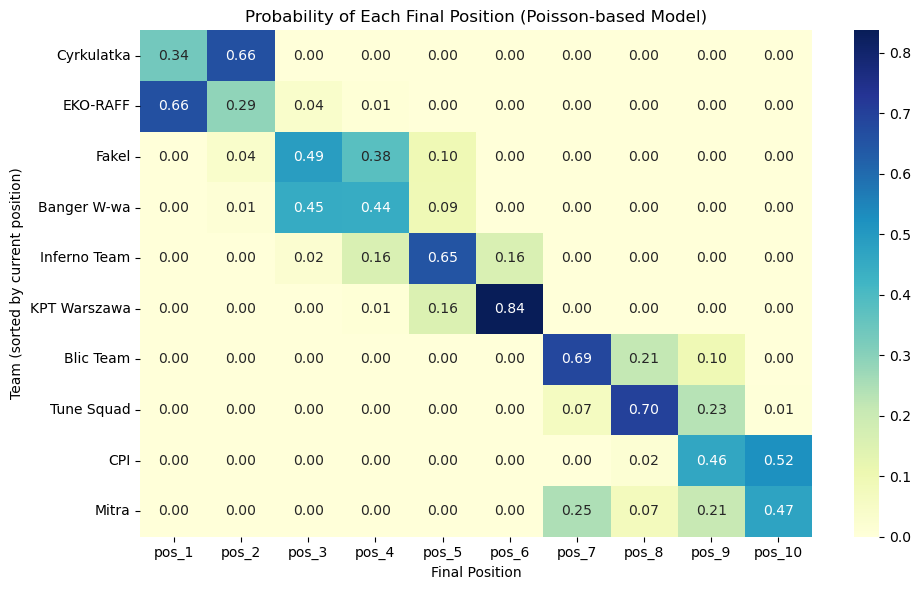

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(prob_table, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Probability of Each Final Position (Poisson-based Model)")
plt.xlabel("Final Position")
plt.ylabel("Team (sorted by current position)")
plt.tight_layout()
plt.show()

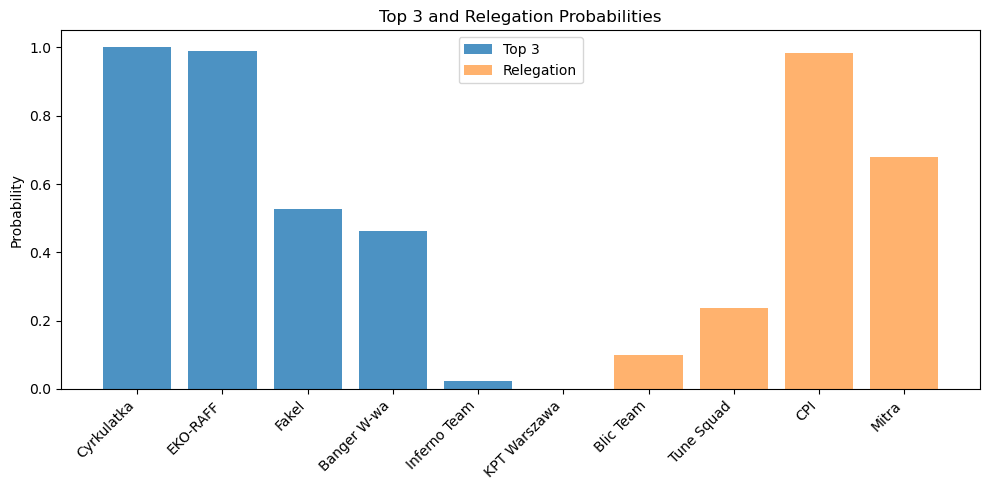

In [11]:
summary_sorted = summary.sort_values("P_top3", ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(summary_sorted.index, summary_sorted["P_top3"], label="Top 3", alpha=0.8)
ax.bar(summary_sorted.index, summary_sorted["P_relegation_9_10"], label="Relegation", alpha=0.6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("Top 3 and Relegation Probabilities")
plt.legend()
plt.tight_layout()
plt.show()

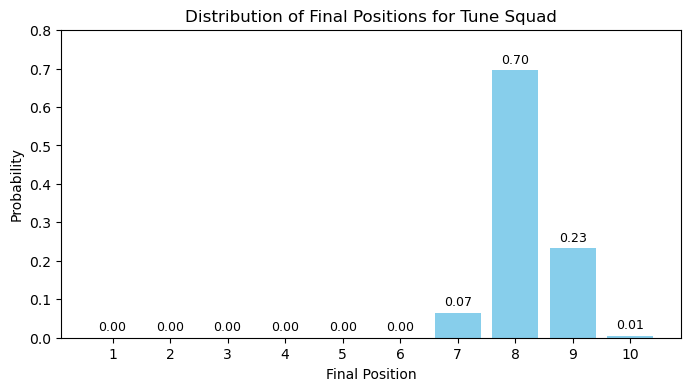

In [12]:
team = "Tune Squad"
positions = np.arange(1, len(teams) + 1)
probs = prob_table.loc[team]

plt.figure(figsize=(8,4))
bars = plt.bar(positions, probs, color="skyblue")

for bar, prob in zip(bars, probs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{prob:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.ylim(0, max(probs)*1.15)

plt.xticks(positions)
plt.xlabel("Final Position")
plt.ylabel("Probability")
plt.title(f"Distribution of Final Positions for {team}")
plt.show()